In [65]:
import os
import ray

In [34]:
import pandas as pd

In [35]:
# Data Ingestion
DATASET_LOC ="https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv" 
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [36]:

from sklearn.model_selection import train_test_split

In [37]:
# Value counts
df.tag.value_counts() #

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [38]:
# split Dataset
test_size = 0.2
train_df, val_dif = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [39]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [40]:
val_dif.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

In [41]:
# Validation (adjusted) value counts
val_dif.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

# Analisis de datos exploratorios (EDA)

In [42]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [43]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

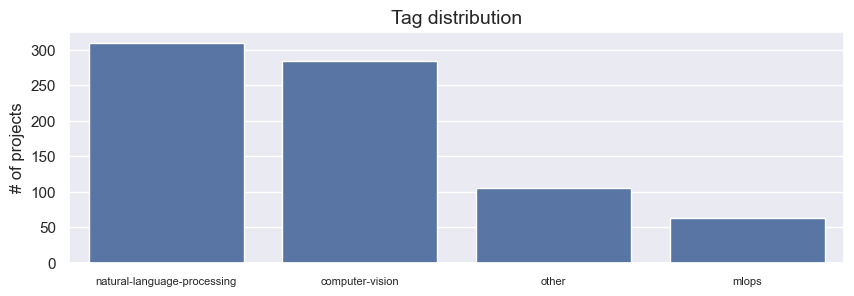

In [44]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

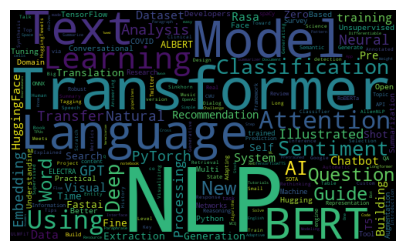

In [45]:
# Most frequent token for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

# Data Preprocessing

In [46]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

In [47]:
# Feature engoneering
df["text"] = df.title + " " + df.description

### Clean text

In [48]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricardoaltamirano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
def clean_text(text, stopwords=STOPWORDS):
    """clean raw text string."""
    # Lower
    text=text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [50]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean Dataframe

In [51]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")   # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]    # rearrange colss
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Codificacion

In [52]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [53]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [54]:
def decode(indices, index_to_class):
    return[index_to_class[index] for index in indices]
    

In [55]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [56]:
# Tokenization
import numpy as np
from transformers import BertTokenizer

##### El tokenizador convertira nuestro texto de entrada en una lista de identificadores de token y una lista de mascaras de atencion. los identificadores de fichas son los indices de los token en el vocabulario. La mascara de atencion es una mascara binaria que indica la posicion de los indices de tokens para que el modelo pueda guardarlos(e ignorar los tokens de almohadilla)

In [57]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to long
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print(tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [58]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))


In [59]:
# Tokenization
tokenize(df.head(1))


{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

In [60]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description    # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore") # clean dataframe
    df = df[["text", "tag"]]    # rearramge columns
    df["tag"] = df["tag"].map(class_to_index)   # label encoding
    outputs = tokenize(df)
    return outputs

In [61]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

### Implementation

In [62]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic


ModuleNotFoundError: No module named 'pyarrow'

# Ingestion

In [63]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

ModuleNotFoundError: No module named 'pyarrow'